<span style="color:red; font-size:200%;">Partie 3: Modeles de prévision de l'emission de CO2 </span>

# Import des bibliothèque necessaire

In [497]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
import time

# Importation des données 

In [498]:
data=pd.read_csv('data_emission_Final.csv')

# Train test split

In [499]:
data=data[data['TotalGHGEmissions']>0]
data['TotalGHGEmissions']=np.log(data['TotalGHGEmissions'])
data['quantile_labels'] = pd.qcut(data['SiteEUIWN(kBtu/sf)'],q=[0,0.25, 0.5, 0.75, 1.0], labels=False)
data=data.drop('SiteEUIWN(kBtu/sf)',axis=1)

In [500]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['TotalGHGEmissions'], axis=1),
    data['TotalGHGEmissions'],
    test_size=0.19,
    random_state=42,
    stratify=data['quantile_labels']  
)

X_test = X_test.drop('quantile_labels',axis=1)

# Les Fonctions 

On présente ci-dessous toutes fonctions utilisées lors de notre prévision commençons par le traçage de residus et la distributions,ensuite fonction pour entrainer notre modeles et choisir les meilleurs hyperparametres,aprés les fonctions de feature importance.

In [501]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, residuals, alpha=0.5)
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Résidus (Real Price - Predicted Price)')
    plt.title('Graphique des résidus')
    plt.axhline(y=0, color='red', linestyle='--')  
    plt.show()

In [502]:
def plot_residuals_and_distribution(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, bins=30, kde=True, color='blue')
    plt.xlabel('Résidus (Real Price - Predicted Price)')
    plt.ylabel('Fréquence')
    plt.title('Distribution des résidus')
    plt.tight_layout()
    plt.show()

In [503]:
def hyperparameter_Fonction(pipline,param_grid,model_name,X_train, y_train, X_test, y_test):
    start_time = time.time()  
    
    random_search=RandomizedSearchCV(pipeline, param_distributions = param_grid, n_iter =30, cv =3,scoring='r2')
    quantile_labels_train = X_train['quantile_labels'].copy()
    XX_train = X_train.drop('quantile_labels',axis=1)
    
    random_search.fit(XX_train, y_train,groups=quantile_labels_train)

    print(f"Meilleurs paramètres: {random_search.best_params_}")

    y_train_pred = random_search.predict(XX_train)
    y_test_pred = random_search.predict(X_test)

    r2_train = random_search.score(XX_train,y_train)
    r2_test = random_search.score(X_test,y_test)
    
    fit_duration = time.time() - start_time  
    cv_scores = cross_val_score(random_search.best_estimator_, XX_train, y_train, cv=3,scoring='r2')
    r2_cv_mean = random_search.best_score_
    print(f"R2-score (Entraînement): {r2_train:.4f}")
    print(f"R2-score (Test): {r2_test:.4f}")
    print(f"R2-score (Validation croisée): {r2_cv_mean:.4f}")
    print("-" * 50)
    plot_residuals(y_test, y_test_pred)
    plot_residuals_and_distribution(y_test, y_test_pred)
    results = {
        'Model': model_name,
        'Best_Params': [random_search.best_params_],
        'R2_Train': [r2_train],
        'R2_Test': [r2_test],
        'R2_CV_Mean': [r2_cv_mean],
        'Fit_Duration': [fit_duration]
    }
    return random_search,results 

In [504]:
all_results_list = []

# Modeles de prévisions

## Regression Lineaire

In [505]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import time

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])
param_grid = {}  

The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Meilleurs paramètres: {}
R2-score (Entraînement): 0.4147
R2-score (Test): 0.3361
R2-score (Validation croisée): 0.3657
--------------------------------------------------


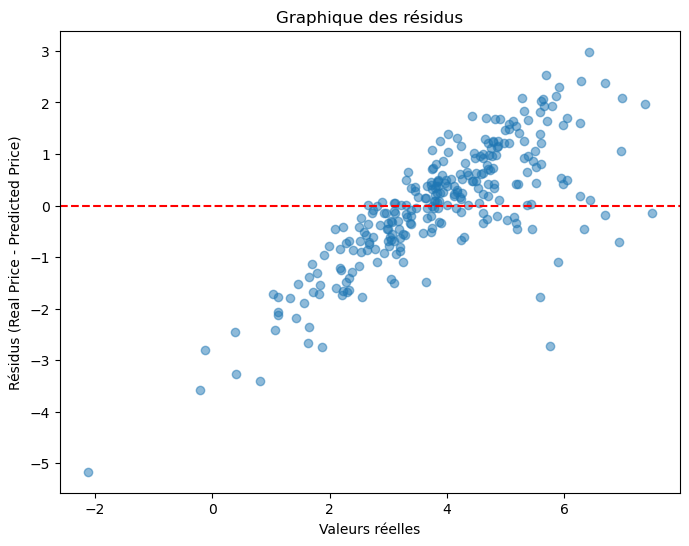

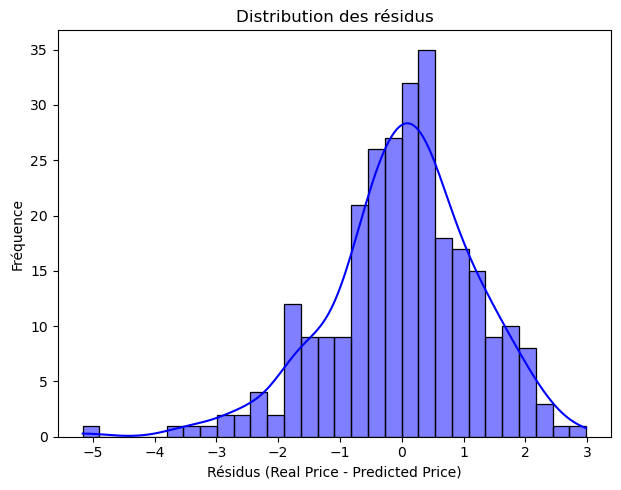

In [506]:
random_search_reg, results_reg = hyperparameter_Fonction(pipeline, param_grid, 'regression',X_train, y_train, X_test, y_test)
all_results_list.append(results_reg)

## Ridge

In [507]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
param_grid = {
    'ridge__alpha': np.logspace(-4,4,100),
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'ridge__max_iter': range(1000, 15000),
    'ridge__tol': [0.0001,0.001,0.01, 0.1,1]
    
}

Meilleurs paramètres: {'ridge__tol': 0.1, 'ridge__solver': 'auto', 'ridge__max_iter': 14016, 'ridge__alpha': 45.34878508128591}
R2-score (Entraînement): 0.4128
R2-score (Test): 0.3327
R2-score (Validation croisée): 0.3805
--------------------------------------------------


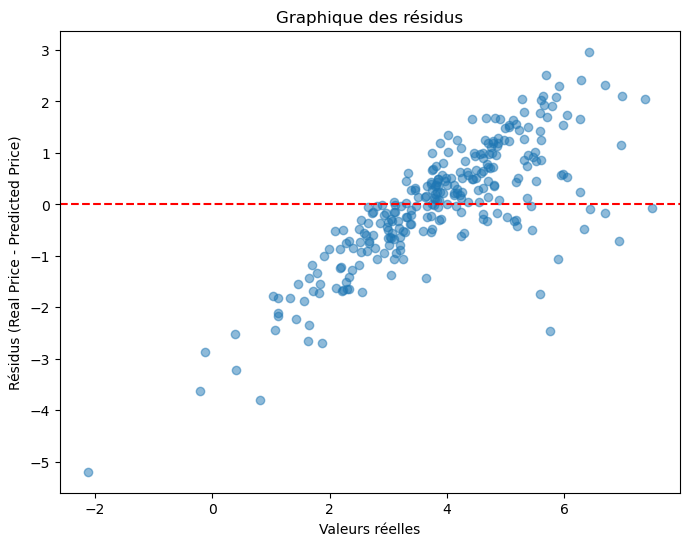

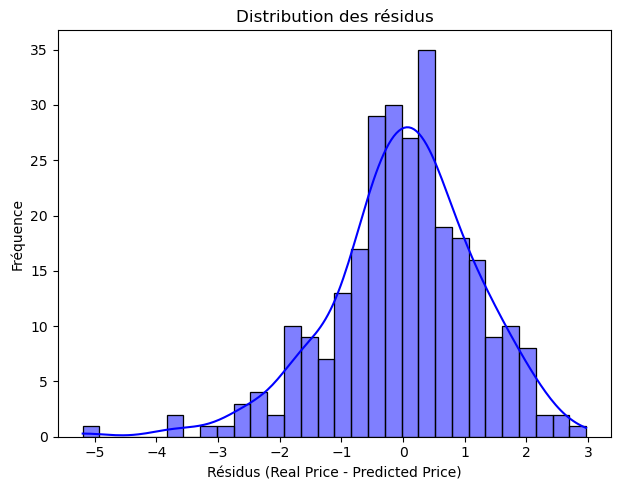

In [508]:
random_search_ridge, results_ridge = hyperparameter_Fonction(pipeline, param_grid, 'Ridge',X_train, y_train, X_test, y_test)
all_results_list.append(results_ridge)

## Lasso

In [509]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

param_grid = {
    'lasso__alpha':[0.001, 0.01, 0.1, 1.0,5, 10.0, 100.0, 1000.0],
    'lasso__fit_intercept': [True, False],
    'lasso__max_iter': range(400, 1000),
    'lasso__tol': [0.001, 0.01, 0.1],
}

Meilleurs paramètres: {'lasso__tol': 0.01, 'lasso__max_iter': 511, 'lasso__fit_intercept': True, 'lasso__alpha': 0.01}
R2-score (Entraînement): 0.4124
R2-score (Test): 0.3417
R2-score (Validation croisée): 0.3819
--------------------------------------------------


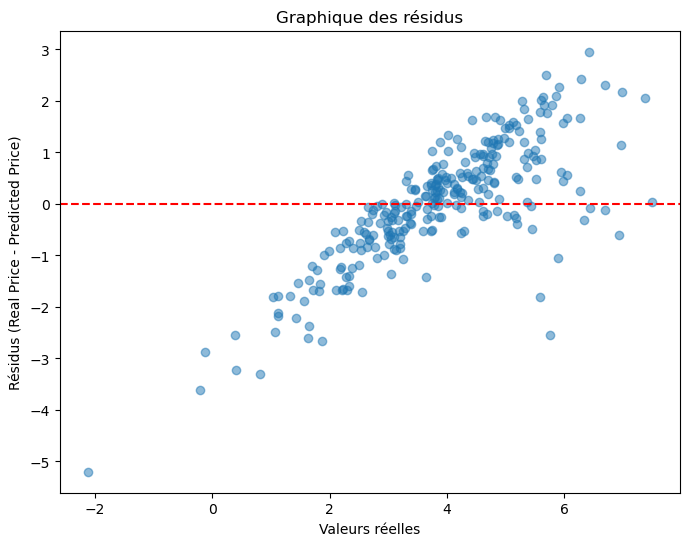

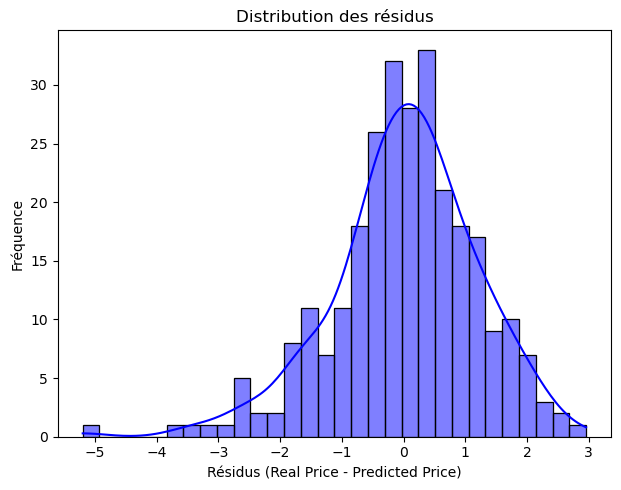

In [510]:
random_search_lasso, results_lasso = hyperparameter_Fonction(pipeline, param_grid, 'Lasso',X_train, y_train, X_test, y_test)
all_results_list.append(results_lasso)

## Elastic Net

In [511]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet())
])

param_grid = {
    'elasticnet__alpha': [0.1,100],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9],
    'elasticnet__fit_intercept': [True, False],
    'elasticnet__max_iter': range(200, 1000),
    'elasticnet__tol': [0.001, 0.01, 0.1],
    'elasticnet__precompute': [True, False],
    'elasticnet__copy_X': [True, False],
    'elasticnet__warm_start': [True, False],
    'elasticnet__positive': [True, False],
    'elasticnet__random_state': [None, 42]
}

Meilleurs paramètres: {'elasticnet__warm_start': False, 'elasticnet__tol': 0.1, 'elasticnet__random_state': 42, 'elasticnet__precompute': True, 'elasticnet__positive': False, 'elasticnet__max_iter': 412, 'elasticnet__l1_ratio': 0.1, 'elasticnet__fit_intercept': True, 'elasticnet__copy_X': True, 'elasticnet__alpha': 0.1}
R2-score (Entraînement): 0.4052
R2-score (Test): 0.3210
R2-score (Validation croisée): 0.3836
--------------------------------------------------


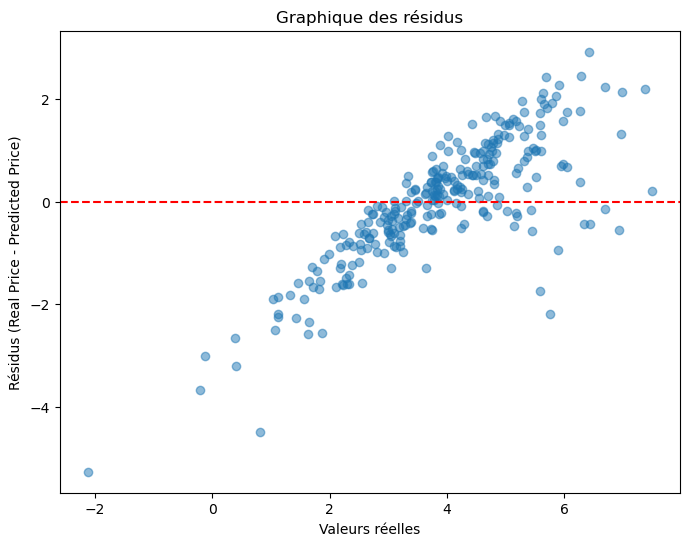

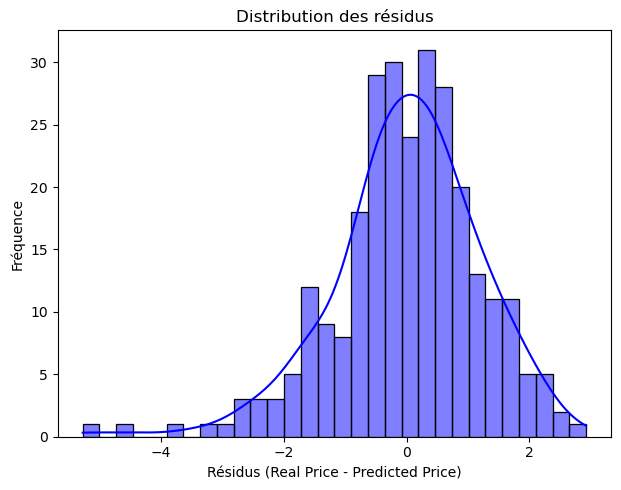

In [512]:
random_search_elastic, results_elastic = hyperparameter_Fonction(pipeline,param_grid,'elasticnet',X_train, y_train, X_test, y_test)
all_results_list.append(results_elastic)

## Random Forest

In [513]:
pipeline = Pipeline([
    ('randomforest', RandomForestRegressor())
])

param_grid = {
    'randomforest__n_estimators': [10,20,30,40,50,60,70],
    #'randomforest__criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    'randomforest__max_depth': [2,3],
    'randomforest__max_features':[0.3,0.4,0.5],
    'randomforest__min_samples_split':  [12,14,16,20],
    'randomforest__min_samples_leaf': [1,2,3,4,6,7,8,9]
}

Meilleurs paramètres: {'randomforest__n_estimators': 40, 'randomforest__min_samples_split': 12, 'randomforest__min_samples_leaf': 3, 'randomforest__max_features': 0.5, 'randomforest__max_depth': 3}
R2-score (Entraînement): 0.4546
R2-score (Test): 0.3684
R2-score (Validation croisée): 0.4048
--------------------------------------------------


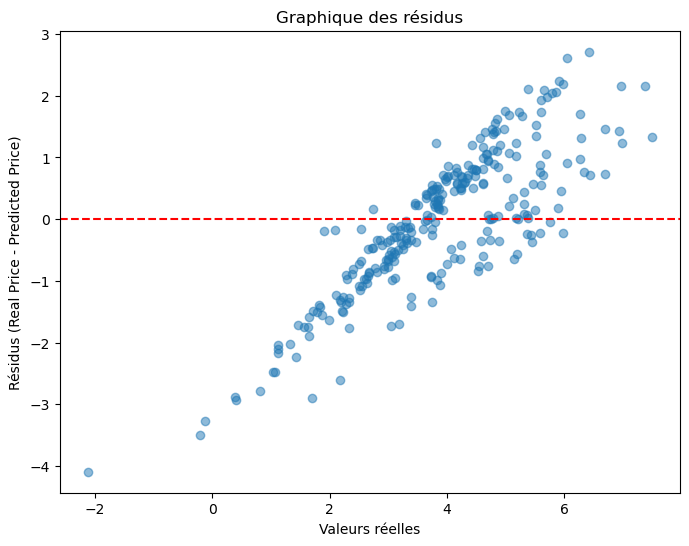

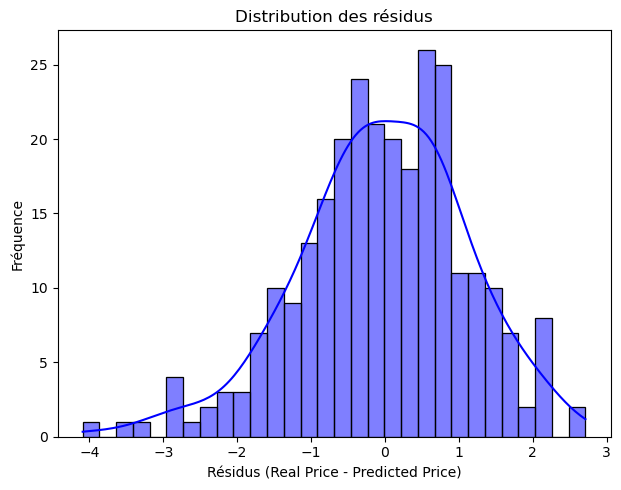

In [514]:
random_search_random, results_random = hyperparameter_Fonction(pipeline,param_grid,'randomforest', X_train, y_train, X_test, y_test)
all_results_list.append(results_random)

## GradientBoosting

In [515]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('GradientBoosting', GradientBoostingRegressor())
])

param_grid = {
    'GradientBoosting__n_estimators': [10,20,30,50,100,200,300,400],
    #'GradientBoosting__learning_rate': [1.e-4,1.e-3,1.e-2,1.e-1],
    'GradientBoosting__max_depth': [2,3],
    'GradientBoosting__max_features':[0.1,0.2,0.5,0.7,0.8,0.9],
    'GradientBoosting__min_samples_split': [20,30,40],
    'GradientBoosting__min_samples_leaf':[10,12,15,17,19,20]
}

Meilleurs paramètres: {'GradientBoosting__n_estimators': 400, 'GradientBoosting__min_samples_split': 40, 'GradientBoosting__min_samples_leaf': 15, 'GradientBoosting__max_features': 0.5, 'GradientBoosting__max_depth': 2}
R2-score (Entraînement): 0.7123
R2-score (Test): 0.4751
R2-score (Validation croisée): 0.5347
--------------------------------------------------


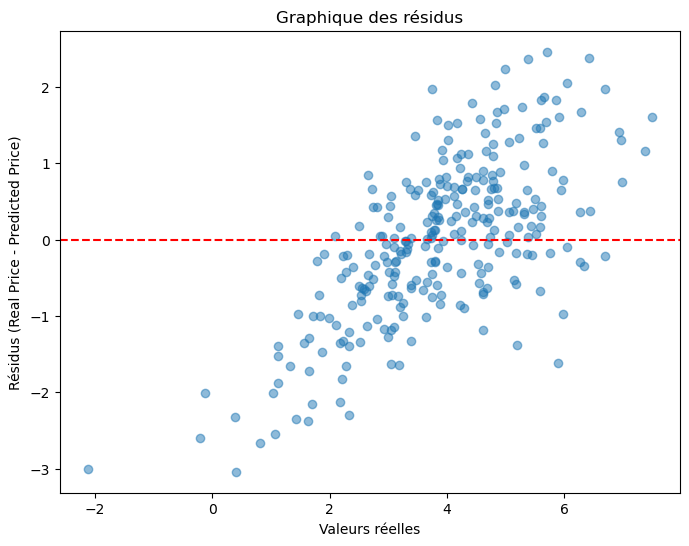

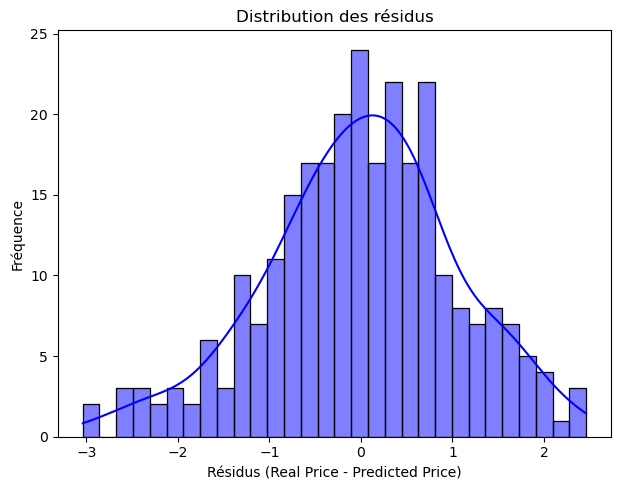

In [516]:
random_search_gradien, results_gradie = hyperparameter_Fonction(pipeline,param_grid,'GradientBoosting', X_train, y_train, X_test, y_test)
all_results_list.append(results_gradie)

# Comparaison des resultats 


In [517]:
all_results = pd.DataFrame(all_results_list)
all_results_sorted = all_results.sort_values(by='R2_Test',ascending=False)
all_results_sorted .head(6)

,Model,Best_Params,R2_Train,R2_Test,R2_CV_Mean,Fit_Duration
5,GradientBoosting,"[{'GradientBoosting__n_estimators': 400, 'Grad...",[0.7122504390761631],[0.47508227709547257],[0.5346575486901967],[45.02725100517273]
4,randomforest,"[{'randomforest__n_estimators': 40, 'randomfor...",[0.454604962010831],[0.3683577982755686],[0.4047714809463326],[11.297764778137207]
2,Lasso,"[{'lasso__tol': 0.01, 'lasso__max_iter': 511, ...",[0.41237794453846],[0.3416994578889383],[0.3819270543167754],[1.1199979782104492]
0,regression,[{}],[0.41466263711615614],[0.33606895471167575],[0.36568365958649834],[0.0729985237121582]
1,Ridge,"[{'ridge__tol': 0.1, 'ridge__solver': 'auto', ...",[0.41282071332902714],[0.3326516172428934],[0.3804553375158721],[2.6125524044036865]
3,elasticnet,"[{'elasticnet__warm_start': False, 'elasticnet...",[0.4052116799658224],[0.32096827207725065],[0.38357868515587734],[1.422532081604004]


    On peut constater que les meilleurs resultats sont obtenues par gradientBoosting avec un R2 score de 0.60 pour le test et 0.50 pour le R2 score de la validation croisée.

# Feature importance

In [518]:
def plot_feature_importance(best_model, feature_names):
    coefficients = best_model[-1].coef_
    sorted_indices = np.argsort(np.abs(coefficients))
    sorted_coefficients = coefficients[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance - Global')
    plt.show()

## Regression lineaire

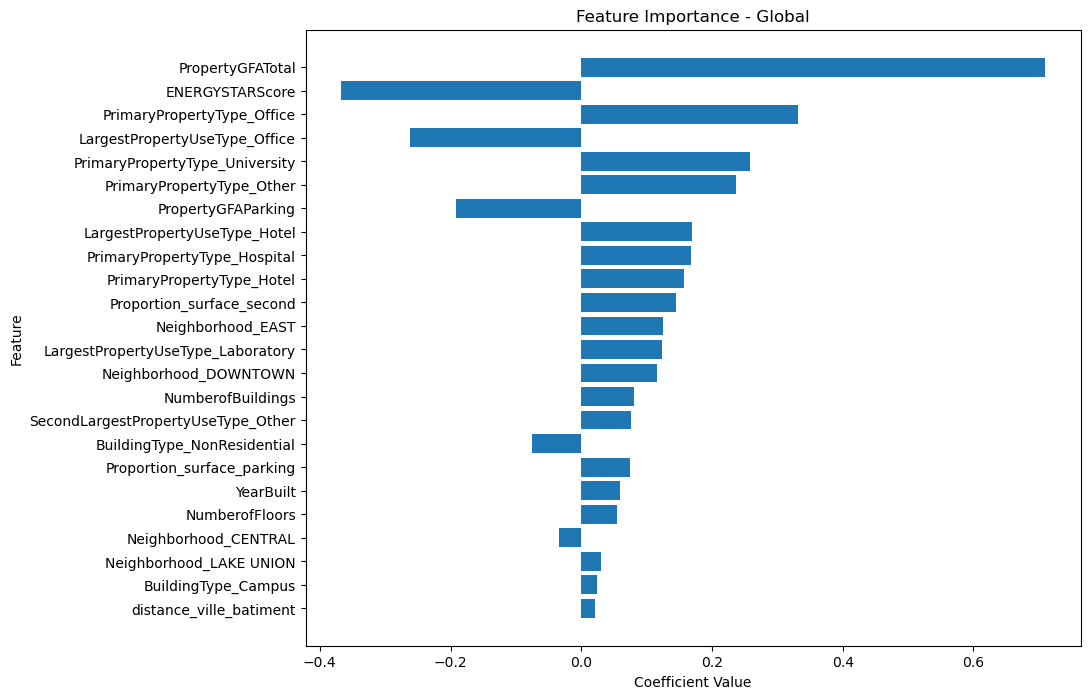

In [519]:
best_params = random_search_reg.best_params_
best_model = random_search_reg.best_estimator_
feature_names = X_train.columns

plot_feature_importance(best_model, feature_names)

Dans ce graphe, la caractéristique "Surface Total" apparaîts avec la plus grande barre, indiquant une importance élevée. Cela suggère que la Surface des Batiments  est le facteur le plus influent dans la prédiction de l'emission de CO2.indique leur contribution relative à la prise de décision du modèle. En interprétant ce graphe, nous pourrions conclure que, selon notre modèle, la taille d'un batiment est le paramètre déterminant dans l'emission de CO2.

## Ridge

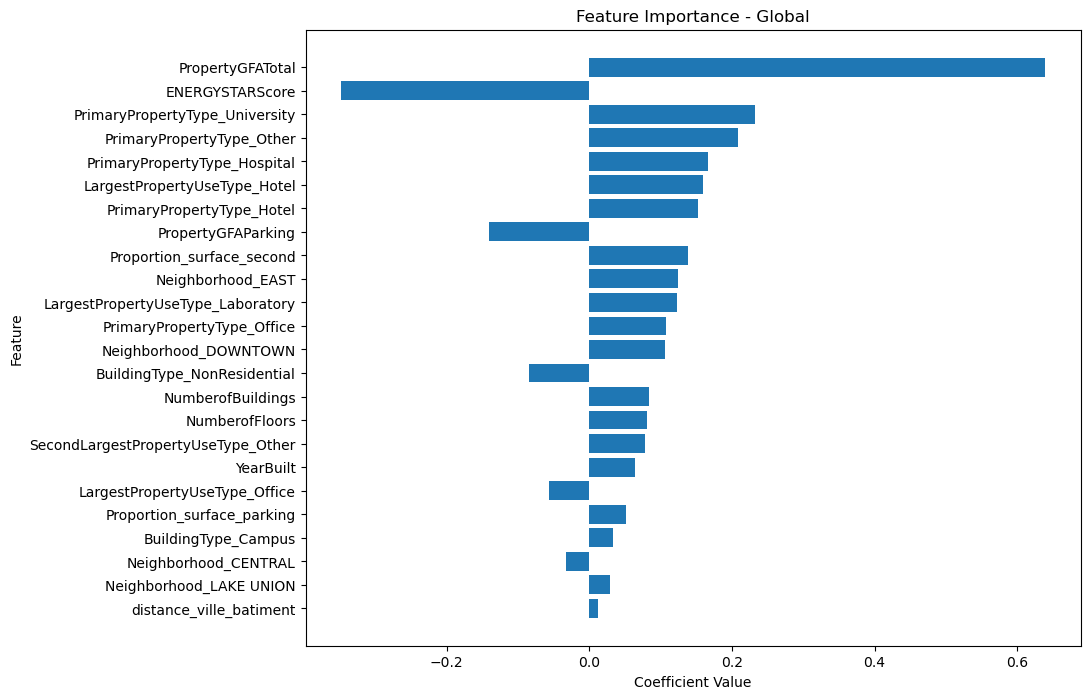

In [520]:
best_params1 = random_search_ridge.best_params_
best_model1 = random_search_ridge.best_estimator_
plot_feature_importance(best_model1, feature_names)

Meme interprétation pour Ridge

# Feature Importance Local

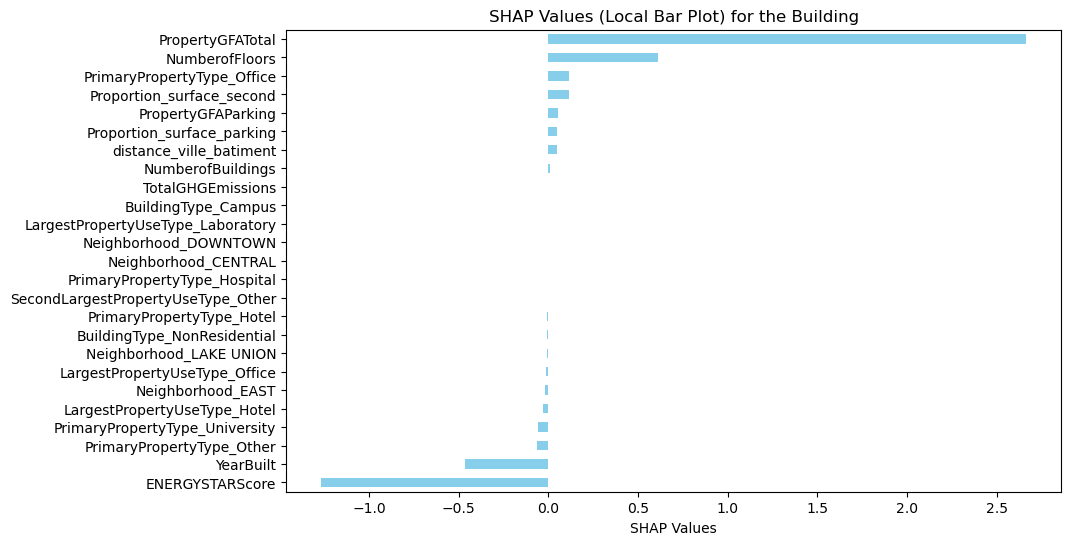

In [521]:
import shap
best_estimator = random_search_gradien.best_estimator_
data=data.drop('quantile_labels',axis=1)
X_building = data.iloc[[0]]
explainer = shap.TreeExplainer(best_estimator.named_steps['GradientBoosting'])
shap_values_building = explainer.shap_values(X_building)
feature_names = X_building.columns
shap_values_building = pd.Series(shap_values_building[0], index=feature_names)
shap_values_building = shap_values_building.sort_values()
plt.figure(figsize=(10, 6))
shap_values_building.plot(kind='barh', color='skyblue')
plt.xlabel('SHAP Values')
plt.title('SHAP Values (Local Bar Plot) for the Building')
plt.show()

Pour le batiment utilisé on peut constater que sa surface  a joué un rôle crucial dans la prédiction de son emission de CO2. Une augmentation significative du surface pour ce batiment est fortement associée à une prédiction de consommation plus élevé, selon le modèle."

# Interet d'EnergyStarScore

In [522]:
# Energy Score
data=data.drop('ENERGYSTARScore',axis=1)

Meilleurs paramètres: {'GradientBoosting__n_estimators': 300, 'GradientBoosting__min_samples_split': 20, 'GradientBoosting__min_samples_leaf': 10, 'GradientBoosting__max_features': 0.5, 'GradientBoosting__max_depth': 3}
R2-score (Entraînement): 0.8063
R2-score (Test): 0.4837
R2-score (Validation croisée): 0.5361
--------------------------------------------------


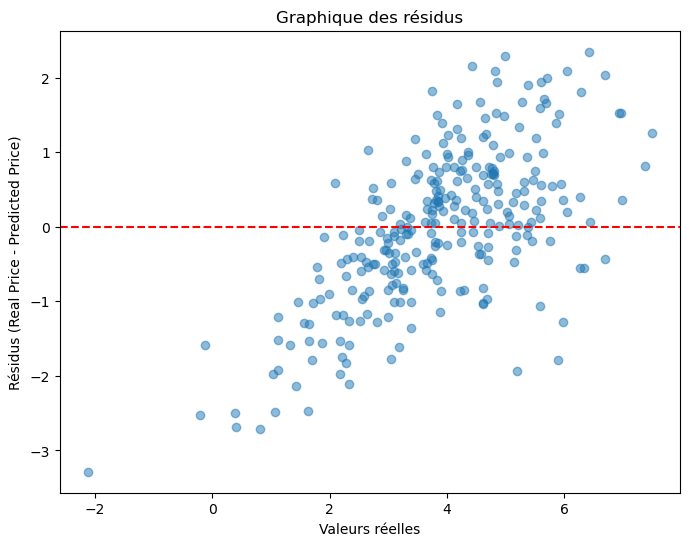

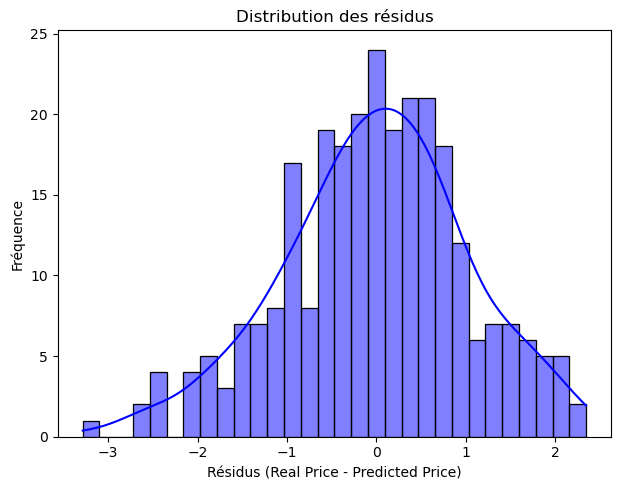

In [523]:
random_search_gradien, results_gradie = hyperparameter_Fonction(pipeline,param_grid,'GradientBoosting', X_train, y_train, X_test, y_test)

On constate que le non utilisation de la caractéristique "ENERGYSTARScore" n'influence pas les résultats de prévision.